In [1]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 53.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
# Importing essential libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation, LSTM, Bidirectional, TimeDistributed
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization  
from keras.utils import np_utils
from scipy import stats
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
def normalize(X):
    for j in range(0, X.shape[1]):
        for k in range(0, X.shape[2]):
            mean = np.mean(X[:, j, k], axis=None)
            stddev = np.std(X[:, j, k], axis=None)
            if stddev == 0:
                X[:, j, k] = mean
            else:
                X[:, j, k] = (X[:, j, k] - mean) / stddev
    return X

In [4]:
# Function to create a data augmentation layer using TensorFlow
def create_data_augmentation_layer():
    return tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),  # Normalize pixel values
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
    ])

In [5]:
import os
from sklearn.model_selection import train_test_split

# Function to load images from a directory
# Function to load images from a directory
def load_images_from_directory(directory, k_max=300):
    X = []
    y = []

    for subfolder_name in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder_name)
        
        for root, dirs, files in os.walk(subfolder_path):
            for file in files:
                if file.endswith(".png"):  # Assuming the images are PNG files
                    image_path = os.path.join(root, file)
                    img = cv2.imread(image_path, 0)
                    Kp, des = sift.detectAndCompute(img, None)
                    Des = np.zeros((k_max, des.shape[1]))

                    # Pad or truncate des to match the shape of Des
                    if des.shape[0] > k_max:
                        des = des[:k_max, :]
                    elif des.shape[0] < k_max:
                        pad_size = k_max - des.shape[0]
                        des = np.pad(des, ((0, pad_size), (0, 0)), mode='constant')

                    Des[:des.shape[0], :des.shape[1]] = des
                    X.append(Des)
                    y.append(int(subfolder_name))

    return np.array(X).astype('float32'), np_utils.to_categorical(y).astype('int32')


# Set the paths to the dataset folders in Kaggle
train_dir = '/kaggle/input/datasets-for-ear-detection-and-recognition/ear recognition datasets/Dataset1/train'
test_dir = '/kaggle/input/datasets-for-ear-detection-and-recognition/ear recognition datasets/Dataset1/test'
validation_dir = '/kaggle/input/datasets-for-ear-detection-and-recognition/ear recognition datasets/Dataset1/validation'

# Initiate SIFT detector
sift = cv2.SIFT_create()

k_max = 300

In [6]:
# Create a data augmentation layer
data_augmentation = create_data_augmentation_layer()

# Load the training data
X_train, y_train = load_images_from_directory(train_dir, k_max)

# Normalize the training data (if not normalized already)
X_train = normalize(X_train)

# Apply data augmentation to the training dataset
train_data_augmented = data_augmentation(X_train)

X_train2 = X_train
y_train2 = y_train

# Concatenate the original and augmented data
X_train = np.vstack((X_train, train_data_augmented))
y_train = np.vstack((y_train, y_train))  # Assuming y_train is one-hot encoded

# Ensure the data shape matches your model's input shape
X_train = X_train.reshape(X_train.shape[0], k_max, 128)

In [7]:

# Load the test data
X_test, y_test = load_images_from_directory(test_dir, k_max)


# Load the validation data
X_val, y_val = load_images_from_directory(validation_dir, k_max)


# Normalize the test data (if not normalized already)
X_test = normalize(X_test)

# Normalize the test data (if not normalized already)
X_val = normalize(X_val)

# Ensure the data shape matches your model's input shape
X_test = X_test.reshape(X_test.shape[0], k_max, 128)

# Ensure the data shape matches your model's input shape
X_val = X_val.reshape(X_val.shape[0], k_max, 128)

# Printing test labels and data shape
print(y_test)
print(X_test[0].shape)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]
(300, 128)


In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Activation, Dropout

def ear_recognition_model(input_shape, num_classes):
    model = Sequential()

    # LSTM layer
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape, activation='tanh'))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation='tanh')))

    # Another Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=128, return_sequences=False, activation='tanh')))

    # Dropout for regularization
    model.add(Dropout(0.2))

    # Fully connected layer
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Define the input shape based on your data (k_max and feature dimension)
input_shape = (k_max, 128)
num_classes = y_train2.shape[1]

# Create the model
model = ear_recognition_model(input_shape, num_classes)

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300, 128)          131584    
                                                                 
 bidirectional (Bidirectiona  (None, 300, 256)         263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 13)               

In [9]:
from sklearn.model_selection import train_test_split


# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train2, y_train2, test_size=0.2, random_state=42)

# Train the model and capture training history
history = model.fit(X_train2, y_train2, validation_data=(X_val, y_val), epochs=10, batch_size=32)
# Adjust the number of epochs and batch size as needed


# Access training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

# Validate the model
validation_loss, validation_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss: {:.4f}".format(validation_loss))
print("Validation Accuracy: {:.2f}%".format(validation_accuracy * 100))

# Additional information about training
print("Training Loss: {:.4f}".format(training_loss[-1]))
print("Training Accuracy: {:.2f}%".format(training_accuracy[-1] * 100))

model.save('my_model.h5') 

Epoch 1/10
49/49 [==============================] - 110s 2s/step - loss: 2.2394 - accuracy: 0.2545 - val_loss: 1.8371 - val_accuracy: 0.3750
Epoch 2/10
49/49 [==============================] - 96s 2s/step - loss: 1.5408 - accuracy: 0.4968 - val_loss: 1.2855 - val_accuracy: 0.5577
Epoch 3/10
49/49 [==============================] - 98s 2s/step - loss: 1.2624 - accuracy: 0.5750 - val_loss: 1.0614 - val_accuracy: 0.6442
Epoch 4/10
49/49 [==============================] - 98s 2s/step - loss: 1.0062 - accuracy: 0.6532 - val_loss: 0.8177 - val_accuracy: 0.7051
Epoch 5/10
49/49 [==============================] - 99s 2s/step - loss: 0.7213 - accuracy: 0.7603 - val_loss: 0.6315 - val_accuracy: 0.7853
Epoch 6/10
49/49 [==============================] - 97s 2s/step - loss: 0.5172 - accuracy: 0.8224 - val_loss: 0.3178 - val_accuracy: 0.8974
Epoch 7/10
49/49 [==============================] - 101s 2s/step - loss: 0.4260 - accuracy: 0.8590 - val_loss: 0.3007 - val_accuracy: 0.8974
Epoch 8/10
49/49 [

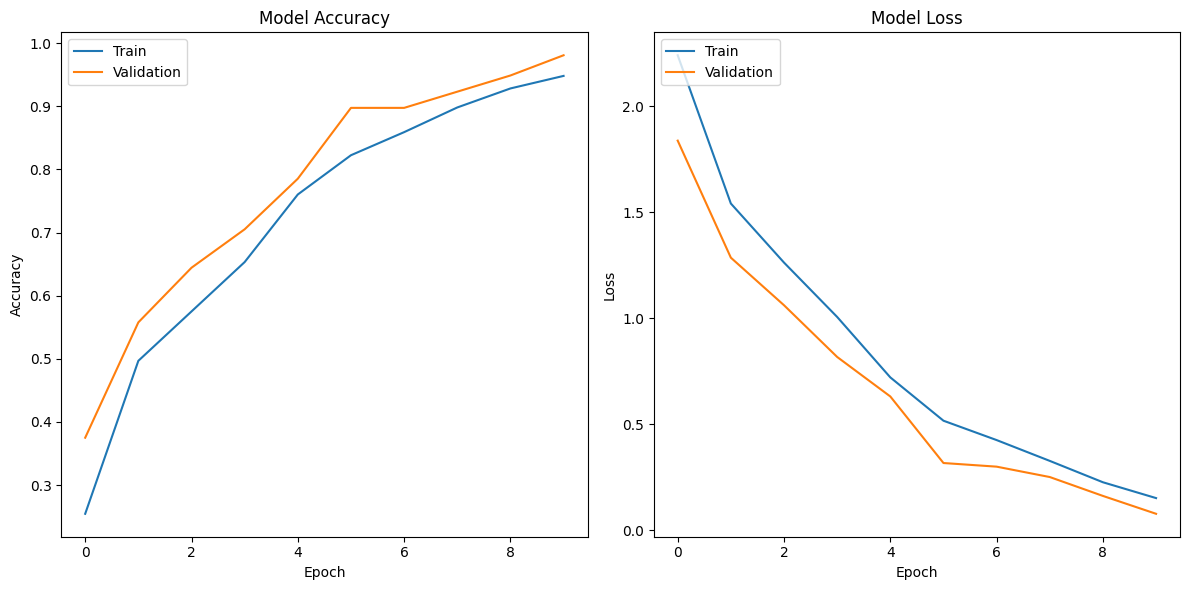

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Define the RCNN model
def rcnn_model(input_shape, num_classes):
    model = keras.Sequential()
    
    # Convolutional layer
    model.add(layers.Conv1D(64, 3, activation='relu', input_shape=input_shape))
    
    # Max-pooling layer
    model.add(layers.MaxPooling1D(pool_size=2))
    
    # Bidirectional LSTM layer
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
    
    # Global max-pooling layer
    model.add(layers.GlobalMaxPooling1D())
    
    # Dense layers
    model.add(layers.Dense(64, activation='relu'))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# Define the input shape and number of classes
input_shape = (X_train2.shape[1], X_train2.shape[2])  # Adapted to your previous input shape
num_classes = y_train2.shape[1]  # Adapted to your number of classes

# Create and compile the RCNN model
model = rcnn_model(input_shape, num_classes)

# Train the RCNN model
historyy = model.fit(X_train2, y_train2, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the RCNN model
accuracy = model.evaluate(X_test, y_test)[1]

# Print the accuracy
print(f"Accuracy on the test set: {accuracy:.2f}")

# Access training history
training_loss = historyy.history['loss']
training_accuracy = historyy.history['accuracy']

# Validate the model
validation_loss, validation_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss: {:.4f}".format(validation_loss))
print("Validation Accuracy: {:.2f}%".format(validation_accuracy * 100))

# Additional information about training
print("Training Loss: {:.4f}".format(training_loss[-1]))
print("Training Accuracy: {:.2f}%".format(training_accuracy[-1] * 100))

model.save('my_model2.h5') 

Epoch 1/10
49/49 [==============================] - 14s 180ms/step - loss: 2.3586 - accuracy: 0.2128 - val_loss: 2.0579 - val_accuracy: 0.3750
Epoch 2/10
49/49 [==============================] - 8s 154ms/step - loss: 1.8348 - accuracy: 0.4269 - val_loss: 1.6141 - val_accuracy: 0.4551
Epoch 3/10
49/49 [==============================] - 7s 152ms/step - loss: 1.4161 - accuracy: 0.5301 - val_loss: 1.2176 - val_accuracy: 0.5962
Epoch 4/10
49/49 [==============================] - 8s 154ms/step - loss: 1.0937 - accuracy: 0.6628 - val_loss: 0.9317 - val_accuracy: 0.7276
Epoch 5/10
49/49 [==============================] - 8s 162ms/step - loss: 0.8650 - accuracy: 0.7308 - val_loss: 0.7593 - val_accuracy: 0.7788
Epoch 6/10
49/49 [==============================] - 8s 157ms/step - loss: 0.6993 - accuracy: 0.7885 - val_loss: 0.6415 - val_accuracy: 0.8301
Epoch 7/10
49/49 [==============================] - 8s 156ms/step - loss: 0.5377 - accuracy: 0.8500 - val_loss: 0.3996 - val_accuracy: 0.9103
Epoch

In [12]:
from sklearn.metrics import precision_score, recall_score

# Make predictions
y_pred = model.predict(X_test)

y_true = y_test

# Assuming y_true and y_pred are one-hot encoded
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# Calculate Precision and Recall with "macro" average
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

# Print the results
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")



17/17 [==============================] - 2s 38ms/step
Precision: 0.6685577590499308
Recall (Sensitivity): 0.6634615384615384


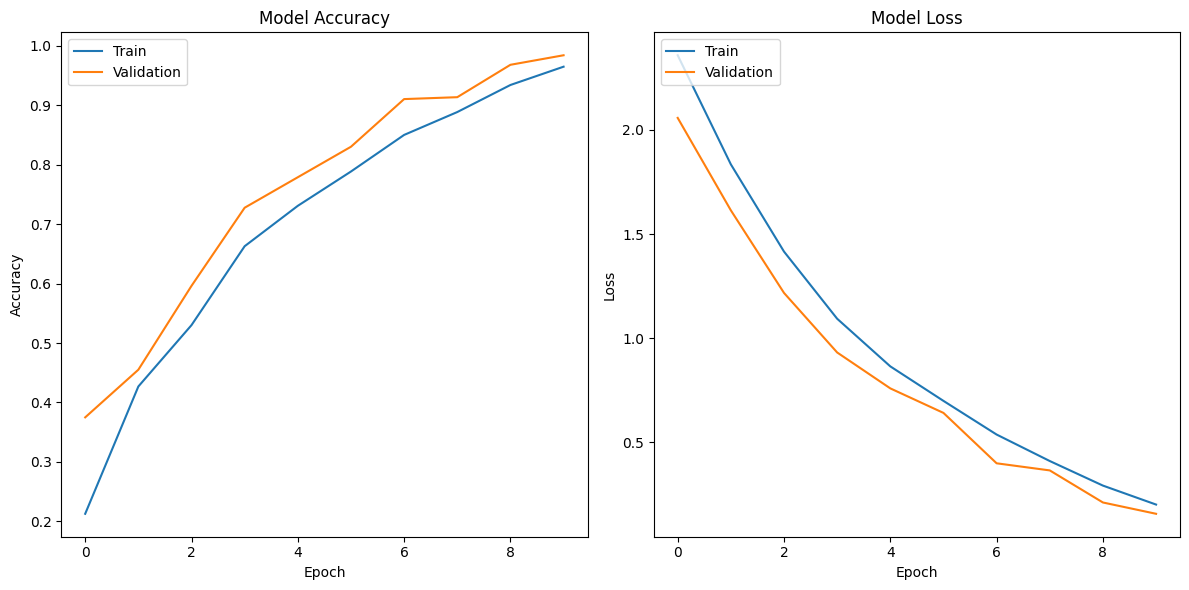

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(historyy.history['accuracy'])
plt.plot(historyy.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(historyy.history['loss'])
plt.plot(historyy.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 [==============================] - 2s 2s/step
The recognized image is an ear.


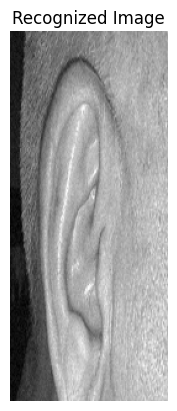

In [14]:
from keras.models import load_model

# Load the trained model
model = load_model('my_model.h5')  # Replace 'my_model.h5' with the actual path to your saved model

# Load and preprocess the new image
image_path = '/kaggle/input/datasets-for-ear-detection-and-recognition/ear recognition datasets/Dataset1/test/001/69gr.png'
img = cv2.imread(image_path, 0)  # Read the image in grayscale

# Preprocess the image as needed to match the input shape of your model
img = cv2.resize(img, (128, k_max))  # Resize to match your model's input shape
img = img / 255.0  # Normalize the pixel values to [0, 1]
img = np.expand_dims(img, axis=0)  # Reshape to match the model's input shape

# Make predictions using the loaded model
predictions = model.predict(img)

# Interpret the predictions
# 'predictions' will contain the model's output, usually as probabilities for each class
# You can find the class with the highest probability as the predicted class
predicted_class = np.argmax(predictions, axis=1)[0]

# Define a threshold for classifying as an "ear"
ear_threshold = 0.5  # You can adjust this threshold as needed

# Determine if the recognized image is an ear or not
is_ear = predictions[0][predicted_class] >= ear_threshold


# Print the result
if is_ear:
    print("The recognized image is an ear.")
else:
    print("The recognized image is not an ear.")
    
# Display the image
plt.imshow(img[0], cmap='gray')  
plt.title("Recognized Image")
plt.axis('off')
plt.show()
